### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
integrals_path = '../../mnova_integrals/sacharoza_calki_raw.csv'

reagents_names = ['saccharose', 'alpha-glucose','beta-glucose', 'fructose']

integrals_separator = '\t'

output_path = '../../mnova_integrals/'

#### Mixture in time

In [5]:
integrals = pd.read_csv(integrals_path, sep = integrals_separator).iloc[:,:-1]
integrals.fillna(0., inplace=True)
integrals.columns = ['ppm'] + ['t' + str(nb) for nb in range(1, integrals.shape[1])]

In [6]:
integrals

,ppm,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t1014,t1015,t1016,t1017,t1018,t1019,t1020,t1021,t1022,t1023
0,-1.76433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
1,-1.76421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
2,-1.76409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
3,-1.76397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
4,-1.76384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131067,14.17670,0.000063,0.000045,-0.000083,-0.000097,0.000035,-0.000007,-0.000008,0.000081,-0.000101,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
131068,14.17680,0.000063,0.000045,-0.000083,-0.000097,0.000035,-0.000007,-0.000008,0.000081,-0.000101,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
131069,14.17700,0.000063,0.000045,-0.000083,-0.000097,0.000035,-0.000007,-0.000008,0.000081,-0.000101,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
131070,14.17710,0.000063,0.000045,-0.000083,-0.000097,0.000035,-0.000007,-0.000008,0.000081,-0.000101,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0


In [7]:
regions = [(5.185803 + 0.2, 5.246521 + 0.2), 
           (5.013715 + 0.2, 5.056501 + 0.2), 
           (4.419116 + 0.2, 4.465992 + 0.2), 
           (3.776692 + 0.2, 3.805767 + 0.2)]
# regions = [(5.185803, 5.246521), 
#            (5.013715, 5.056501), 
#            (4.419116, 4.465992), 
#            (3.776692, 3.805767)]
# Why shift? -> email 2024-07-23 16:37

In [8]:
integrals_in_regions = []
for region in regions:
    lower, upper = region
    cut_data = integrals[integrals['ppm'].apply(lambda x: (x>lower and x<upper))]
    integral = cut_data.iloc[:,1:].sum(axis=0)
    integrals_in_regions.append(integral)

In [9]:
final_df = pd.DataFrame(data = ['t' + str(nb) for nb in range(1, integrals.shape[1])], 
                       columns = ['time'])
for i, integral in enumerate(integrals_in_regions):
    final_df[reagents_names[i]] = integral.values
final_df['whole spectrum'] = integrals.iloc[:,1:].sum(axis=0).values

In [10]:
final_df

,time,saccharose,alpha-glucose,beta-glucose,fructose,whole spectrum
0,t1,55.307649,0.546429,0.135635,1.210039,145.460380
1,t2,54.904272,0.332075,0.136512,1.128275,144.247810
2,t3,54.652991,0.360179,0.137265,1.344470,144.657965
3,t4,55.184382,0.577856,0.131852,1.215964,144.919165
4,t5,55.224362,0.627234,0.142093,1.485835,146.126194
...,...,...,...,...,...,...
1018,t1019,15.795251,6.551382,3.214638,27.518472,132.302728
1019,t1020,15.822921,6.520217,3.119388,27.400416,131.790220
1020,t1021,15.942540,6.546894,3.230344,27.569403,132.504862
1021,t1022,15.796128,6.573377,3.198603,27.205089,131.393781


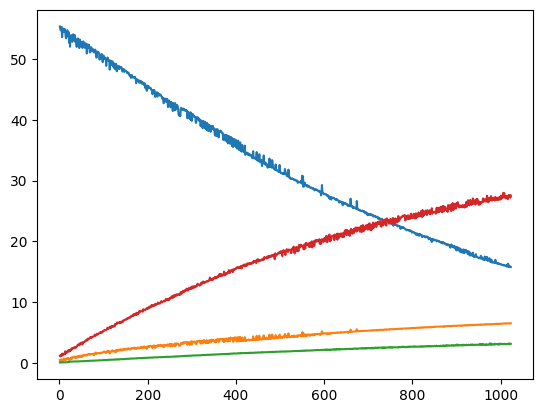

In [11]:
plt.plot(range(1,1024), final_df.iloc[:,1])
plt.plot(range(1,1024), final_df.iloc[:,2])
plt.plot(range(1,1024), final_df.iloc[:,3])
plt.plot(range(1,1024), final_df.iloc[:,4])
#plt.plot(range(1,1024), final_df.iloc[:,5])

### Saving preprocessed spectra

In [12]:
final_df.to_csv(output_path + 'sacharoza_calki.csv', '\t', index=False)